### PAIR IX MÓDULO 3: Ajuste

Para los ejercicios de Pair hemos utilizado el siguiente dataset: [Spotify Tracks Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset)

In [6]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Gráficos
# ==============================================================================
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Asunciones y Preprocesamiento
# ==============================================================================
from scipy import stats
import math
from scipy.stats import levene
import researchpy as rp
from sklearn.preprocessing import StandardScaler
import itertools

# ANOVA
# ==============================================================================
import statsmodels.api as sm
from statsmodels.formula.api import ols

#  Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#  Crossvalidation
# ------------------------------------------------------------------------------
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

El objetivo de este pairprogramming es que hagáis vuestro primer modelo de machine learning. Para eso recordad que:
- Deberéis separar la X y la y.
- Deberéis crear el train y el test.
- Ajustar vuestro modelo.

In [7]:
df = pd.read_pickle('data/spotify_songs_estandarizado_encoding.pkl')
df.head(2)

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,owners_F_G,owners_G,owners_G_A,owners_major,owners_minor,owners_compas_1,owners_compas_2,owners_compas_3,owners_compas_4,owners_compas_5
0,18,-0.184255,-0.157447,0.025974,-0.153345,4.038855,-0.065621,-0.000916,0.100897,-0.102381,...,0,0,0,0,1,0,0,0,1,0
1,58,-0.832951,0.612766,-0.194805,0.225755,7.351738,-0.116098,-0.000916,-0.266256,-0.038095,...,0,1,0,1,0,0,0,0,1,0


Vamos a probar qué tal sale con el entrenamiento y test:

In [10]:
X = df.drop("popularity", axis = 1)
y = df["popularity"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lr = LinearRegression(n_jobs=-1)

lr.fit(x_train, y_train)

y_predict_train = lr.predict(x_train)
y_predict_test = lr.predict(x_test)

train_df = pd.DataFrame({'Real': y_train, 'Predicted': y_predict_train, 'Set': ['Train']*len(y_train)})
test_df  = pd.DataFrame({'Real': y_test,  'Predicted': y_predict_test,  'Set': ['Test']*len(y_test)})
resultados = pd.concat([train_df,test_df], axis = 0)


resultados['residuos'] = resultados['Real'] - resultados['Predicted']
resultados.head()

,Real,Predicted,Set,residuos
9182,2,34.218988,Train,-32.218988
11091,8,36.239438,Train,-28.239438
6428,0,35.329042,Train,-35.329042
288,0,33.237269,Train,-33.237269
2626,60,35.122888,Train,24.877112


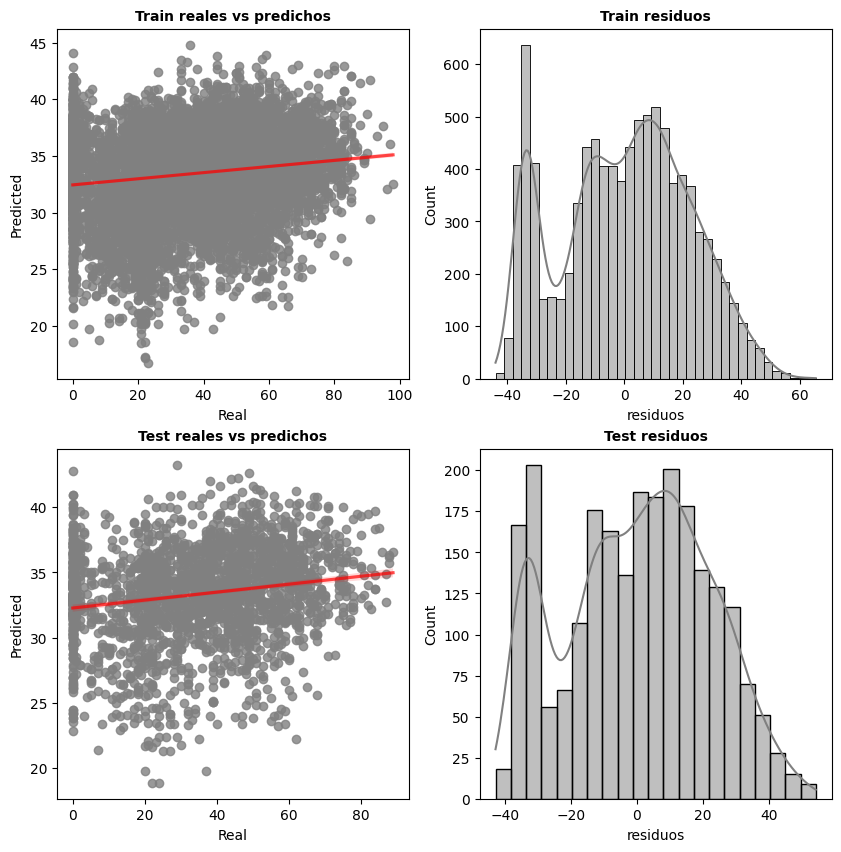

In [11]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

sns.regplot(data = resultados[resultados['Set'] == "Train"], 
            x = "Real", 
            y = "Predicted", 
            ax = ax[0,0], 
            color = "grey",
            line_kws = {"color": "red", "alpha": 0.7 })

sns.regplot(data = resultados[resultados['Set'] == "Test"], 
            x = "Real",
            y = "Predicted", 
            color = "gray",
            line_kws = {"color": "red", "alpha": 0.7 }, 
            ax = ax[1,0])

sns.histplot(resultados[resultados['Set'] == "Train"],
             x="residuos",
             color ="grey",
             kde=True, 
             ax = ax[0,1])

sns.histplot(resultados[resultados['Set'] == "Test"],
             x="residuos",
             color = "grey",
             kde=True, 
             ax = ax[1,1])

ax[0,0].set_title("Train reales vs predichos", fontsize = 10, fontweight = "bold")
ax[0,1].set_title("Train residuos", fontsize = 10, fontweight = "bold")
ax[1,0].set_title("Test reales vs predichos", fontsize = 10, fontweight = "bold")
ax[1,1].set_title("Test residuos", fontsize = 10, fontweight = "bold");

Según este tipo de entrenamiento, parece que la predicción no ha resultado muy ajustada:
- En los regplots los valores predichos no se ajustan a la línea de tendencia.
- Viendo los histogramas de residuos, parece que muestran que la predicción tampoco es buena: en general los residuos se reparten de manera uniforme entre -40 y 40 (lo ideal sería que se acercasen a cero sin ser todos los valores cero).

Era de esperar que estas predicciones no fuesen buenas puesto que nuestros datos no cumplen las asunciones requeridas para aplicar regresión lineal.

Vamos a probar ahora con el cross validation

In [12]:
cv_scores = cross_validate(
                estimator = LinearRegression(),
                X         = X,
                y         = y,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = 10)

# Se convierte el diccionario a dataframe para facilitar la visualización
cv_scores = pd.DataFrame(cv_scores)

print(f'la media para el r2 es {cv_scores["test_r2"].mean().round(2)}')
print(f'la media para el RMSE es {abs(cv_scores["test_neg_root_mean_squared_error"].mean()).round(2)}')

la media para el r2 es 0.02
la media para el RMSE es 22.04


A la vista de estos datos, podemos de nuevo concluir que este modelo no predice correctamente nuestra variable respuesta: las variables predictoras no explican la variacion de la VR.

Con respecto al RMSE, teniendo en cuenta que lo correcto sería que se acercase a 0, nos indica que nuestro modelo se equivocaría en 22.04 puntos.